In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

from diffusion_edf.graph_parser import RadiusBipartite, InfiniteBipartite
from diffusion_edf.gnn_data import FeaturedPoints, GraphEdge

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = 'cuda:0'
irreps = "1x0e+1x1e+1x2e"

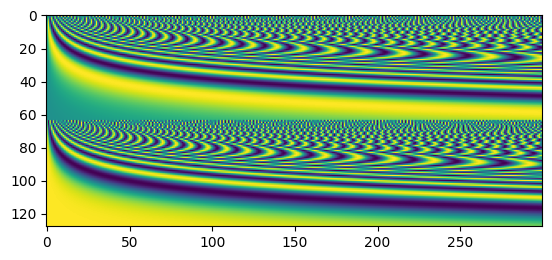

In [3]:
graph_parser = InfiniteBipartite(
    irreps_sh=irreps,
    r_mincut_nonscalar_sh=0.2,
    length_enc_dim=128,
    length_enc_max_r = 2.
).to(device)

graph_parser: InfiniteBipartite = torch.jit.script(graph_parser)

###### Figure #######
out = graph_parser.length_enc(torch.linspace(0,graph_parser.length_enc.max_val, 300))
plt.imshow(out.permute(1,0))

In [4]:
src_pcd = FeaturedPoints(x=torch.tensor([[0., 0., 0.],
                                         [0., 0., 1.],
                                         [0., 1., 0.]], device=device), f=torch.randn(3,3, device=device), b=torch.zeros(3, device=device, dtype=torch.long))
dst_pcd = FeaturedPoints(x=torch.tensor([[0., 0., 0.15],
                                         [0., 0., 1.9]], device=device), f=torch.randn(2,3, device=device), b=torch.zeros(2, device=device, dtype=torch.long))

In [5]:
graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)
torch.stack([graph_edge.edge_src, graph_edge.edge_dst])
graph_edge.edge_scalars.shape
print(f"edge length: {graph_edge.edge_length}\n")
print(f"edge length rel: {graph_edge.edge_length / graph_parser.length_enc.max_val}\n")
print(f"edge cutoff: {graph_edge.edge_weights}\n")
print(f"scalar norm: {graph_edge.edge_attr[...,0]}\n")
print(f"spin-1 norm: {graph_edge.edge_attr[...,1:4].norm(dim=-1)}\n")
print(f"spin-2 norm: {graph_edge.edge_attr[...,4:9].norm(dim=-1)}\n")

edge length: tensor([0.1500, 1.9000, 0.8500, 0.9000, 1.0112, 2.1471], device='cuda:0')

edge length rel: tensor([0.0750, 0.9500, 0.4250, 0.4500, 0.5056, 1.0735], device='cuda:0')

edge cutoff: None

scalar norm: tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')

spin-1 norm: tensor([1.0905, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321], device='cuda:0')

spin-2 norm: tensor([1.4078, 2.2361, 2.2361, 2.2361, 2.2361, 2.2361], device='cuda:0')



# Speed Test

In [6]:
####### Warm Up #######
for _ in range(10):
    src_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device), f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
    dst_pcd = FeaturedPoints(x=torch.randn(100,3, device=device) + 2., f=torch.randn(100,3, device=device), b=torch.zeros(100, device=device, dtype=torch.long))
    graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)

In [7]:
src_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device), f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
dst_pcd = FeaturedPoints(x=torch.randn(100,3, device=device) + 2., f=torch.randn(100,3, device=device), b=torch.zeros(100, device=device, dtype=torch.long))

for _ in tqdm(range(5000)):
    graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)

100%|██████████| 5000/5000 [00:01<00:00, 3084.21it/s]


In [8]:
len(graph_edge.edge_src) # Graph size does not make big difference

100000

In [9]:
src_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device), f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
dst_pcd = FeaturedPoints(x=torch.randn(100,3, device=device) + 4., f=torch.randn(100,3, device=device), b=torch.zeros(100, device=device, dtype=torch.long))

for _ in tqdm(range(5000)):
    graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)

100%|██████████| 5000/5000 [00:01<00:00, 3084.74it/s]


In [10]:
len(graph_edge.edge_src) # Graph size does not make big difference

100000

In [11]:
src_pcd = FeaturedPoints(x=torch.randn(1000,3, device=device), f=torch.randn(1000,3, device=device), b=torch.zeros(1000, device=device, dtype=torch.long))
dst_pcd = FeaturedPoints(x=torch.randn(100,3, device=device) + 4., f=torch.randn(100,3, device=device), b=torch.zeros(100, device=device, dtype=torch.long))

for _ in tqdm(range(5000)):
    graph_edge: GraphEdge = graph_parser(src_pcd, dst_pcd)

100%|██████████| 5000/5000 [00:01<00:00, 2996.50it/s]


In [12]:
len(graph_edge.edge_src) # smaller max_neighbor => slightly faster (c.f. max_neighbors = 1000 is default)

100000